In [1]:
import torch
import pandas as pd
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import decomposition

# Task 1. (10 점) 데이터 준비하기
Task 1-1. (5 점) 파일을 다운로드 받고 ua.base 파일(학습데이터)과 ua.test 파일(검증데이터)의 내용을 불러와서 Tensor 데이터 생성하기

In [2]:
train = pd.read_csv("./ua.base", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("./ua.test", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])

items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

Task 1-2. (5 점) u.item 파일로부터 영화 id와 title 불러오기

In [3]:
movie = pd.read_csv("./u.item", sep="|", names=['id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 
                                               'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 
                                               'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 
                                               'War', 'Western'], encoding='latin-1')

movieInfo = movie[["id", "title"]]
movieInfo

,id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


# Task 2. (20 점) Latent Factor 모델을 이용하여 학습하기
Task 2-1. (3 점) P, Q, bias_user, bias_item 등 파라미터 초기화하기  
Task 2-2. (7 점) regularization과 bias 적용하여 가설, 비용 설정하기  
Task 2-3. (5 점) torch.optim을 사용하여 학습하기

In [4]:
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)

mean = ratings.sum() / len(ratings)

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.1)

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

X = []
Y = []
Y_test = []

for epoch in range(1001):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + \
        bias_item[items] + bias_user[users]
    mse = F.mse_loss(hypothesis ,ratings)
    cost = mse + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum() + \
        lambda3 * (bias_item ** 2).sum() + lambda4 * (bias_user ** 2).sum()

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + \
            bias_item[items_test] + bias_user[users_test]
        mse_test = F.mse_loss(hypo_test, ratings_test)

        X.append(epoch)
        Y.append(mse.item() ** 0.5)
        Y_test.append(mse_test.item() ** 0.5)

    if epoch % 100 == 0:
        print("epoch: {}, cost: {:.6f}".format(epoch, mse.item()))

epoch: 0, cost: 12.350594
epoch: 100, cost: 0.631679
epoch: 200, cost: 0.608255
epoch: 300, cost: 0.606238
epoch: 400, cost: 0.605113
epoch: 500, cost: 0.604151
epoch: 600, cost: 0.603521
epoch: 700, cost: 0.603189
epoch: 800, cost: 0.602900
epoch: 900, cost: 0.602524
epoch: 1000, cost: 0.602249


Task 2-4. (5 점) 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기 (training RMSE, test RMSE)

Training RMSE : 0.7760468595872926
Test RMSE      : 0.9534008690002848


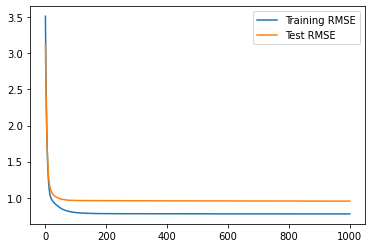

In [5]:
print("Training RMSE :", mse.item() ** 0.5)
print("Test RMSE      :", mse_test.item() ** 0.5)

plt.plot(X, Y, label="Training RMSE")
plt.plot(X, Y_test, label="Test RMSE")
plt.legend()
plt.show()

# Task 3. (10 점) 13번 User에게 추천하기 (knn search)
Task 3-1. (5 점) 13번 user의 예상 별점이 가장 높은 영화 top 20개를 찾아서 id 및 영화이름 출력하기

In [6]:
recom = []

for i in range(len(P)):
    recom.append([i, (torch.sum(P[i] * Q[13]) + mean + bias_item[i] + bias_user[13]).item()])

df = pd.DataFrame(recom, columns=("id", "rating"))
merge = pd.merge(df, movieInfo, on='id', how='inner').sort_values("rating", ascending=False)[:20]
merge[["id", "title"]]

,id,title
49,50,Star Wars (1977)
180,181,Return of the Jedi (1983)
171,172,"Empire Strikes Back, The (1980)"
134,135,2001: A Space Odyssey (1968)
173,174,Raiders of the Lost Ark (1981)
256,257,Men in Black (1997)
662,663,Being There (1979)
510,511,Lawrence of Arabia (1962)
186,187,"Godfather: Part II, The (1974)"
99,100,Fargo (1996)


Task 3-2. (5 점) Latent Matrix P와 Q를 이용하여 13번 user와 cosine similarity가 가장 유사한 영화 top 20개를 찾아서 id 및 영화이름 출력하기

In [7]:
cs = []

for i in range(len(P)):
    cs.append([i, F.cosine_similarity(P[i], Q[13], 0).item()])

cs_df = pd.DataFrame(cs, columns=("id", "cosine_similarity"))
cs_merge = pd.merge(cs_df, movieInfo, on='id', how='inner').sort_values("cosine_similarity", ascending=False)[:20]
cs_merge[["id", "title"]]

,id,title
813,814,"Great Day in Harlem, A (1994)"
867,868,Hearts and Minds (1996)
866,867,"Whole Wide World, The (1996)"
847,848,"Murder, My Sweet (1944)"
908,909,Dangerous Beauty (1998)
591,592,True Crime (1995)
1540,1541,"Beans of Egypt, Maine, The (1994)"
810,811,Thirty-Two Short Films About Glenn Gould (1993)
914,915,Primary Colors (1998)
899,900,Kundun (1997)


# Task 4. (30 점) 영화 클러스터링하기 (k-means clustering)
Task 4-1. (15 점) 다음을 만족하는 k-means clustering 알고리즘 구현하기
- 각 영화가 속한 cluster를 정할 때, cosine similarity를 기준으로 정하기


In [152]:
def cosine_similarity(a, b, eps=1e-8):
    return np.dot(a, b) / (np.linalg.norm(a)+eps * (np.linalg.norm(b)+eps))

def assign(p, centroids):
    min_c_idx = 0
    min_c_dist = -1000000000
    for i, c in enumerate(centroids):
        dist = np.max(cosine_similarity(p, c))
        if min_c_dist <= dist:
            min_c_dist = dist
            min_c_idx = i
    return min_c_idx

def cost(p, centroids):
    co_dist = []
    for aa in range(len(p)):
        for i, c in enumerate(centroids):
            co_dist.append(np.sum(1 - cosine_similarity(p[aa], c)))
    return co_dist

def compute_centroids(k, assignments, points):
    clusters = [ [] for _ in range(k) ]

    for a, p in zip(assignments, points):
        clusters[a].append(p)

    return [np.mean(c, axis=0) for c in clusters]

def kmeans(k, points):
    prev_assignments = []
    centroids = random.choices(points, k=k)
    co = [cost(p, centroids) for p in points]

    for epoch in range(10):
        assignments = [assign(p, centroids) for p in points]
        centroids = compute_centroids(k, assignments, points)

        if prev_assignments == assignments: break
        prev_assignments = assignments
        
    return assignments, centroids, co

Task 4-2. (10 점) k=1, ..., 40 까지 바꿔가면서 cost 값을 계산하고 이를 matplotlib을 활용하여 그래프로 그리기

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


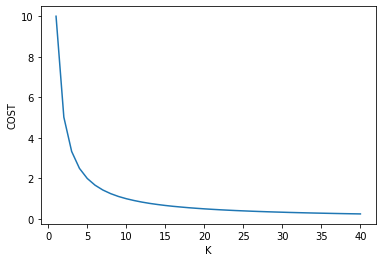

In [155]:
ra = range(1, 41)
p_cost = []
for k in ra:
    assignments, centroids, co = kmeans(k, P.detach().numpy())
    p_cost.append(np.mean(co)/k)

plt.plot(ra, p_cost)
plt.xlabel("K")
plt.ylabel("COST")
plt.show()

Task 4-3. (5 점) 가장 적절해보이는 k 선택하기

In [153]:
ideal = []
ideal.append(kmeans(3, P.detach().numpy())[0])

# Task 5. (30 점) 차원 축소 및 시각화 (PCA)
Task 5-1. (5 점) P 행렬와 Q 행렬을 합쳐 Z행렬 만들기

In [10]:
Z = (torch.cat((P, Q), 0)).detach().numpy()
Z

array([[ 3.31399007e-24,  4.90696174e-24, -1.28973836e-23, ...,
        -4.09563566e-25,  4.84778377e-24,  1.87320071e-24],
       [-2.07048684e-01,  8.08978200e-01, -2.81043798e-01, ...,
        -3.36309344e-01,  8.90510440e-01, -1.65653154e-01],
       [-4.56114024e-01,  9.54865664e-02, -1.00813076e-01, ...,
        -2.79860467e-01,  4.57609922e-01, -2.41856202e-01],
       ...,
       [ 8.73525813e-02,  3.08844805e-01, -1.57717094e-01, ...,
        -5.05302362e-02,  1.05598532e-01, -1.19629003e-01],
       [-8.93785879e-02,  4.88385320e-01, -1.02748953e-01, ...,
         2.59528428e-01,  2.44982809e-01,  2.29926690e-01],
       [ 3.91488552e-01,  2.91138381e-01, -1.31672502e+00, ...,
        -6.80792093e-01,  4.00512934e-01,  4.06006157e-01]], dtype=float32)

Task 5-2. (10 점) Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기
- 참고: 외부 library를 사용해도 무방함


In [11]:
pca = decomposition.PCA(2)
pca.fit(Z)
Zp = pca.transform(Z)

Zp

array([[-0.05043938,  0.01876125],
       [ 0.15153131, -0.46881706],
       [-0.40813434, -0.35403702],
       ...,
       [ 0.16343589,  0.08897001],
       [ 0.27802902, -0.44532073],
       [ 0.64703   , -0.14794637]], dtype=float32)

Task 5-3. matplotlib을 활용하여 Zp의 scatter plot 그리기
- Task 5-3-1. (5 점) P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기


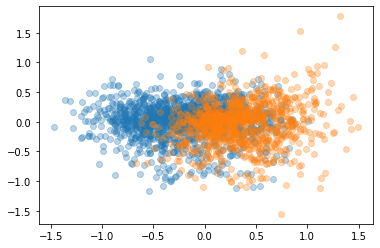

In [12]:
plt.scatter(Zp[:len(P), 0], Zp[:len(P), 1], alpha=0.3)
plt.scatter(Zp[len(P):, 0], Zp[len(P):, 1], alpha=0.3)
plt.show()

- Task 5-3-2. (5 점) Task 3의 결과 점들을 다른 색으로 그려 강조하기


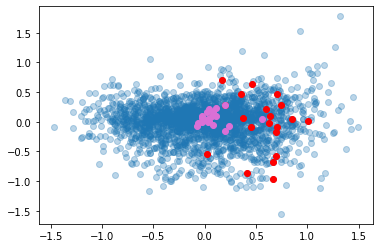

In [13]:
mp = merge["id"]
cp = cs_merge["id"]

plt.scatter(*zip(*Zp), alpha=0.3)
plt.scatter(*zip(*Zp[mp]), c="red")
plt.scatter(*zip(*Zp[cp]), c="orchid")
plt.show()

- Task 5-3-3. (5 점) Task 4에서 구한 cluster들을 각기 다른 색으로 그리기

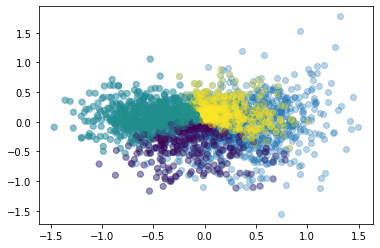

In [154]:
plt.scatter(*zip(*Zp), alpha=0.3)
plt.scatter(Zp[:len(P), 0], Zp[:len(P), 1], c=ideal, alpha=0.3)
plt.show()